In [ ]:
import nibabel as nb
import numpy as np
import pandas as pd 
from nilearn import plotting
from fragmenter import Fragment
from fragmenter import adjacency

This is a simple demo of the parcellation fragmenter, from simple use to some benchmarks. The first step is to load a template surface (in this case, the inflated fsaverage).

In [2]:
testSurface = nb.freesurfer.read_geometry(
    '/Users/Claudio/Desktop/parcellation_fragmenter-modularization/freesurfer/fsaverage/surf/rh.inflated'
)

Surfaces are a 2D triangular mesh, so that each data-containing vertex is tied to 2 neighbors by a triangle. When loading it, you get a tuple of two arrays: the coordinates of each vertex and the vertex's direct neighbors (faces).

In [3]:
testSurface

(array([[ -6.77207661,  10.74224281,  63.36345291],
        [  7.45265865, -43.94926453,  43.67302322],
        [ 40.67627335,   8.6865921 ,  15.46871376],
        ...,
        [ 20.50901985,  -7.89210987, -66.16957092],
        [ 20.29653549,  -8.46869278, -65.95698547],
        [ 20.08860397,  -8.99943542, -65.75714111]]),
 array([[     0,  40964,  40962],
        [     0,  40962,  40965],
        [     0,  40965,  40967],
        ...,
        [163841, 160926,  39990],
        [163113, 160926, 163841],
        [163113,     11, 160926]], dtype=int32))

The fsaverage mesh is composed of ~164k vertices, which we can confirm here.

In [28]:
np.shape(testSurface[0])[0]

163842

In order to parcellate a surface, we derive the neighbors of each vertex. You can consider this to be an adjacency matrix that allows for standard clustering methods to be computed on it. The `adjacency` function will give you this list.

In [33]:
# Create a surface adjacency object
M = adjacency.SurfaceAdjacency(testSurface[0], testSurface[1])

# Generate adjacency list
M.generate()

# Visualize
M.adj

{0: [40962, 40964, 40965, 40967, 40969],
 1: [40992, 150713, 150714, 40989, 40991],
 2: [40994, 40996, 152901, 151443, 151444],
 3: [40972, 40974, 40975, 40977, 149982],
 4: [149252, 149253, 40979, 40981, 40982],
 5: [149984, 40984, 40986, 40987, 149983],
 6: [156550, 156551, 41006, 41008, 158008],
 7: [159467, 41009, 41011, 158009, 158010],
 8: [40997, 152902, 152903, 40999, 159468],
 9: [153632, 153633, 41000, 41002, 155090],
 10: [156549, 41003, 41005, 155091, 155092],
 11: [163113, 162384, 161655, 160925, 160926],
 12: [41025, 144362, 144363, 41012, 41014, 41023],
 13: [41062, 41064, 149739, 146072, 146071, 149496],
 14: [145339, 41042, 41015, 41017, 41019, 144606],
 15: [144608, 41030, 41032, 41020, 41022, 144607],
 16: [146560, 146561, 150470, 150227, 41077, 41079],
 17: [41027, 41029, 41037, 41039, 144851, 144852],
 18: [151200, 41092, 41094, 147049, 147050, 150957],
 19: [145095, 145096, 41034, 41036, 41043, 41045],
 20: [151687, 147538, 41107, 147539, 41109, 151930],
 21: [145

In order to fragment a surface, we first create a `Fragment` object that takes in the desired number of clusters, and whether you want to use pretty colors (T/F). In this case, we will run a simple 10 parcel example.

In [5]:
testFragment = Fragment.Fragment(n_clusters=10)

Once the object is defined, you can check that the number of clusters is right.

In [6]:
testFragment

Now we are ready to fit the number of clusters onto the provided surface. Coordinates and vertices are provided separately (meaning that you could just cluster custom, non-cortical meshes). The following example 

In [7]:
testFragment.fit(vertices = testSurface[0], faces=testSurface[1], method = 'k_means')

This will add an attribute to `testFragment` called `label_`, which is the parcel label associated with each vertex. We can confirm this by checking that length of the resulting vector is equal to the number of vertices in fsaverage.

In [8]:
nVerts = np.size(testFragment.label_)
nVerts

163842

And we can see that the number of labels produced is equal to our desired number (10)

In [9]:
np.unique(testFragment.label_)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32)

And now we can plot the 10 parcels onto a surface (**FIX THIS SO WE CAN USE VIEW_SURF INSTEAD**).

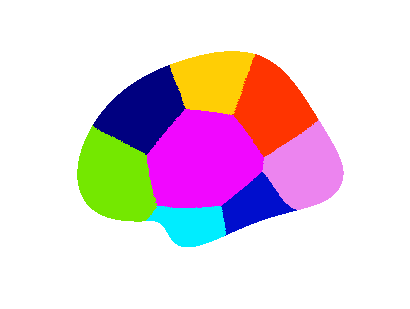

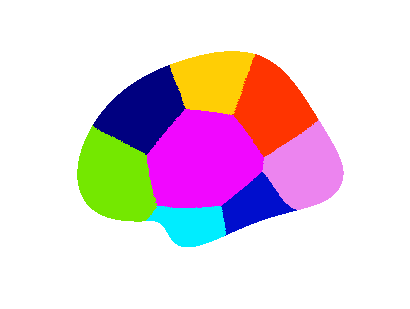

In [10]:
plotting.plot_surf_roi(list(testSurface), testFragment.label_)

In [21]:
from sklearn import metrics

metrics.adjusted_rand_score(testFragment.label_, test)

0.9768698767383124

In [22]:
metrics.jaccard_similarity_score(testFragment.label_, test)

0.98939221933326

In [24]:
(testFragment.label_ == test).mean()

0.98939221933326